In [2]:
import pandas as pd
import pathlib
import numpy as np
import scipy
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import decoupler as dc

import utils

def PEM(X):
    # Xi expression of the gene in tissue i
    Xi = X.sum(1,keepdims=1)
    # Si summary of the expression of all gene in tissue i
    Si = X.sum(0)

    return (Si.sum() / Si) * (X / Xi) 

# Within sample analysis

In [2]:
# adata_tpm = utils.load_rnaseq_sample_selected_tissues_anndata(
#      X_path="../results/rnaseq_sample_selected_tissues_tpm.mm",
#      samples_metadata_path="../results/rnaseq_sample_selected_tissues_metadata.csv",
# )
# # subset to yarn-filtered genes
# genes_rows_path="../results/rnaseq_sample_selected_tissues_yarn_normalized_genes_rows.csv",
# adata_tpm = adata_tpm[:,genes_rows_path['Name'].values]
# progeny = dc.get_progeny(top=500)
# dc.run_gsva(mat=adata_tpm, net=progeny, use_raw=False)

# Between sample analysis

/home/jo/anaconda3/envs/gtex/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


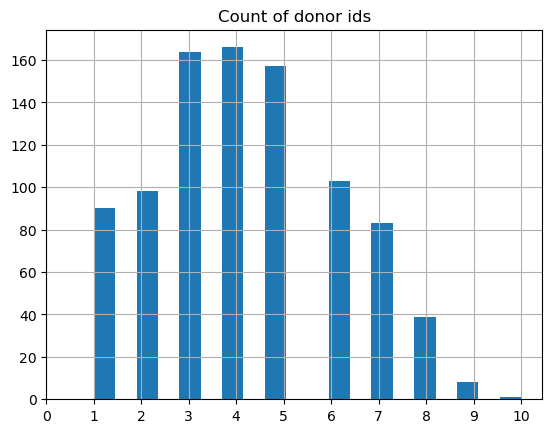

In [3]:
adata = utils.load_rnaseq_sample_selected_tissues_anndata(
    X_path="../results/1_rnaseq_sample_selected_tissues_qsmooth.parquet",
    genes_rows_path="../results/1_rnaseq_sample_selected_tissues_qsmooth_genes.csv",
    genes_names_path="../results/0_rnaseq_sample_selected_tissues_genes_rows.csv",
    samples_metadata_path="../results/0_rnaseq_sample_selected_tissues_QC_metadata.csv",
    )

adata.layers['qsmooth'] = adata.X
if 'log1p' not in adata.uns:
    sc.pp.log1p(adata)
sc.pp.pca(adata)

adata.obs['donor_ids'].value_counts().hist(bins=20)
plt.xticks(np.arange(11))
plt.title('Count of donor ids')
plt.savefig('../figures/1_count_donor_ids.png',dpi=100,bbox_inches='tight')
plt.show()

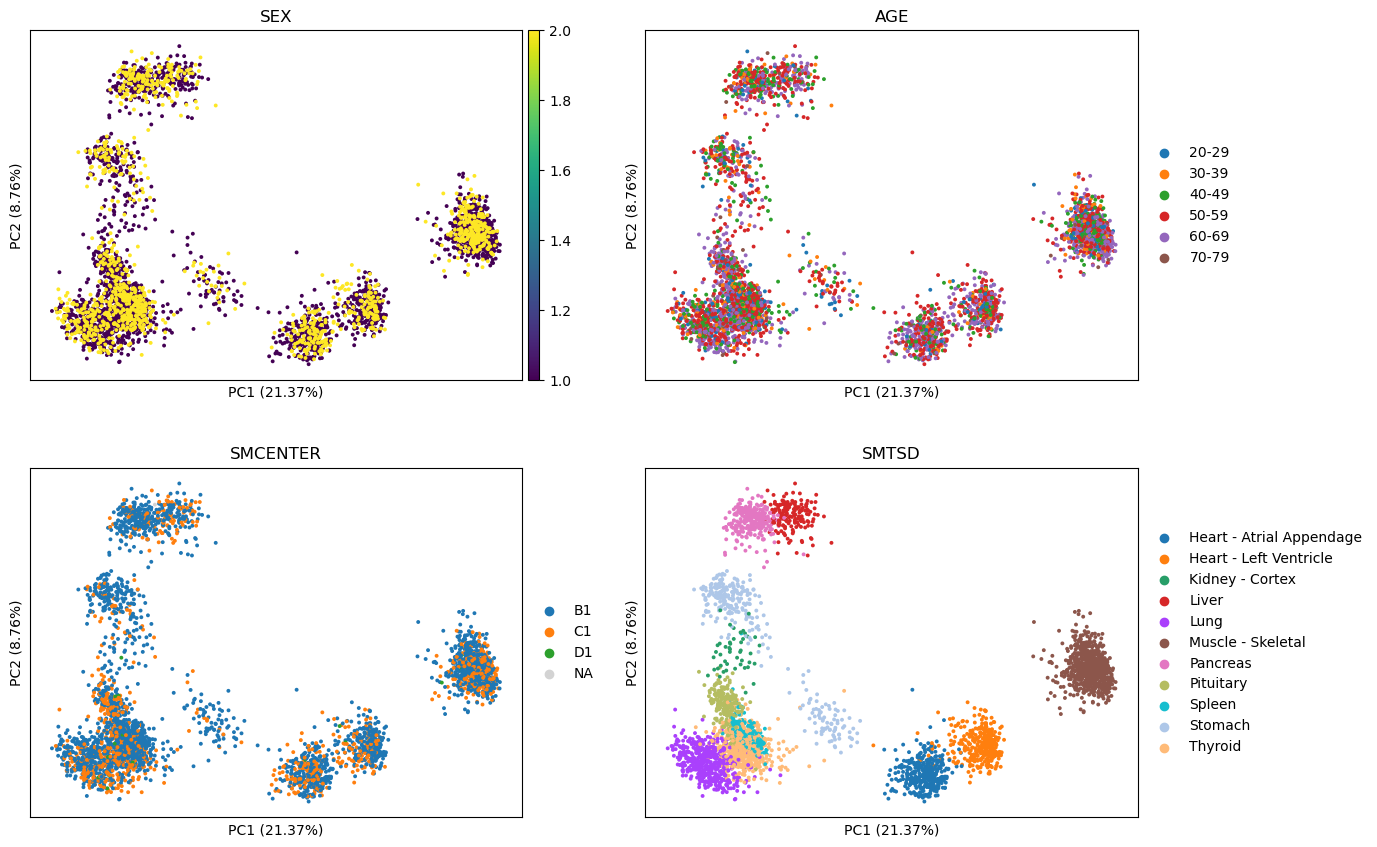

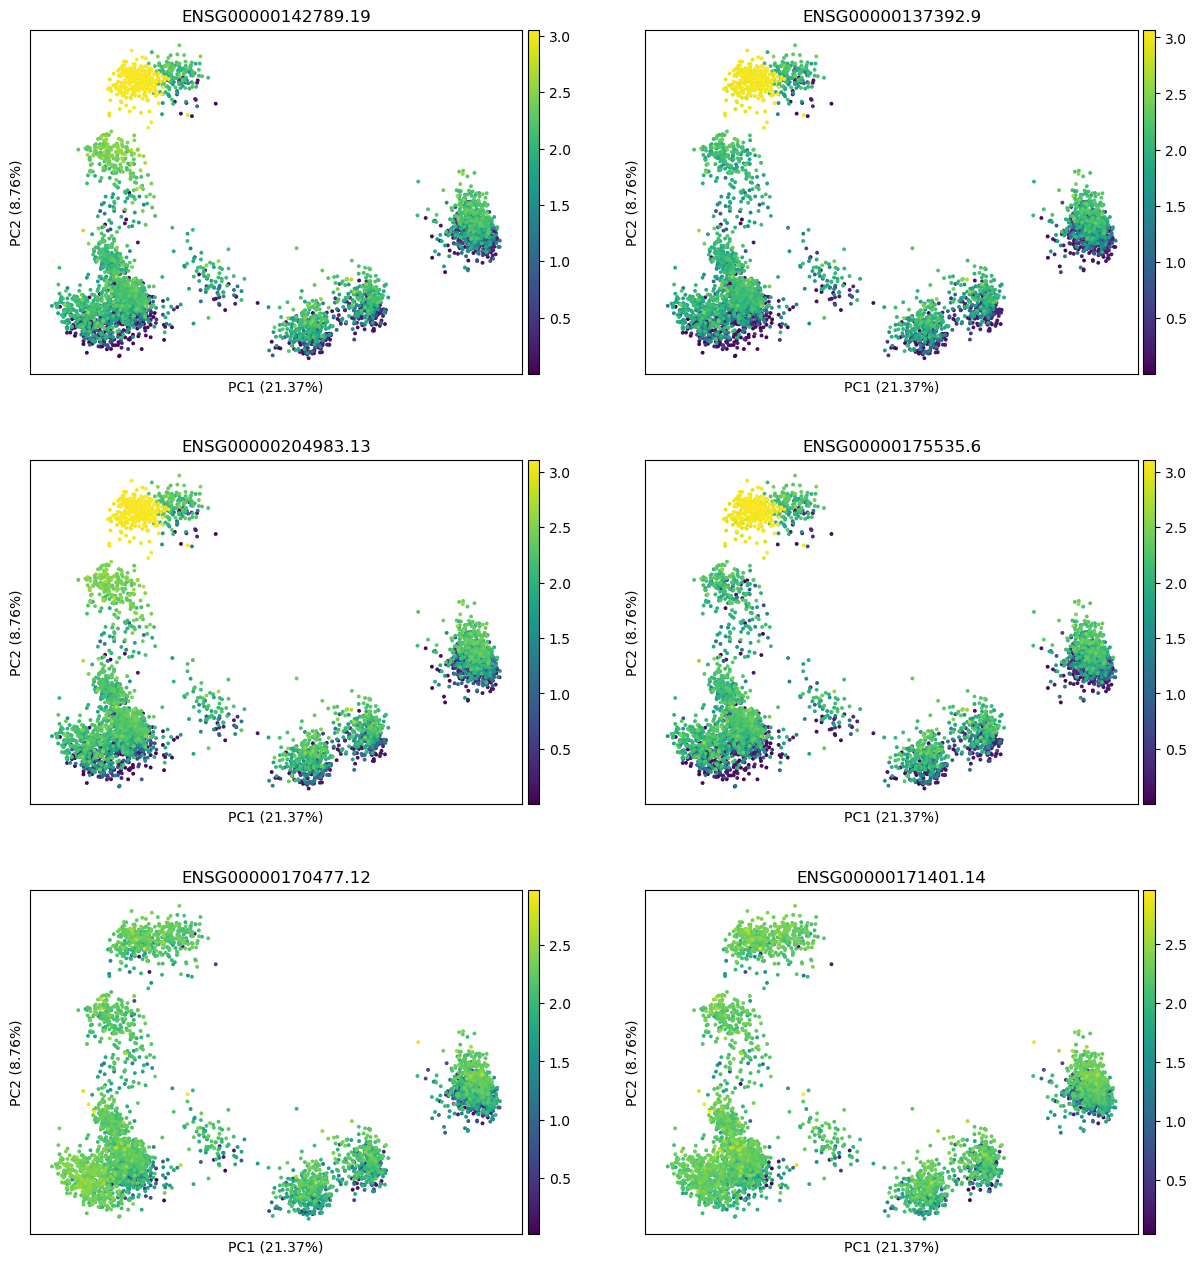

In [4]:
contaminating_genes = adata.var_names[adata.var['Description'].isin(['PRSS1', 'CELA3A', 'PNLIP', 'CLPS', 'KRT4', 'KRT13'])]
sc.settings.figdir=pathlib.Path('../figures/')
sc.pl.pca(adata,color=['SEX','AGE','SMCENTER','SMTSD'],ncols=2,annotate_var_explained=True,save='qsmooth_PCA_covariates.png')
sc.pl.pca(adata,color=contaminating_genes,ncols=2,annotate_var_explained=True,save='qsmooth_PCA_contaminating_genes.png')

## Simple specificity metrics on qsmooth normalized data

In [ ]:
tissue_means = {}
for tissue in adata.obs['SMTSD_grouped'].unique():
    tissue_idx = adata.obs['SMTSD_grouped'] == tissue
    tissue_means[tissue] = pd.Series(adata[tissue_idx].layers['qsmooth'].mean(0),index=adata.var_names)

pdata = sc.AnnData(pd.DataFrame(tissue_means).T)
pdata.obs['SMTSD_grouped'] = pdata.obs_names
pdata.obs['SMTSD_grouped'] = pdata.obs['SMTSD_grouped'].astype('category')

X_pem = PEM(pdata.X)

# sc.pp.log1p(pdata)
# sc.pp.pca(pdata)
# sc.pl.pca(pdata,color='SMTSD_grouped',s=200,annotate_var_explained=True,save='qsmooth_PCA_pseudobulk.png')

## Differential expression on qsmooth normalized data

In [5]:
sc.tl.rank_genes_groups(adata,groupby='SMTSD',method='wilcoxon',key_added='tissue_pairwise_wilcoxon')

results_df = sc.get.rank_genes_groups_df(adata,group='Liver',key='tissue_pairwise_wilcoxon').set_index('names').join(adata.var).set_index('Description')

# LYNX1 is a duplicated name but not in collectri network and can be safely renamed here
results_df.index = [(c if c!= 'LYNX1' else c+f'{i}') for i, c in enumerate(results_df.index)]
# input to TF activity inference with collectri
mat = results_df[['scores']].T.rename(index={'scores': 'liver.vs.rest'})

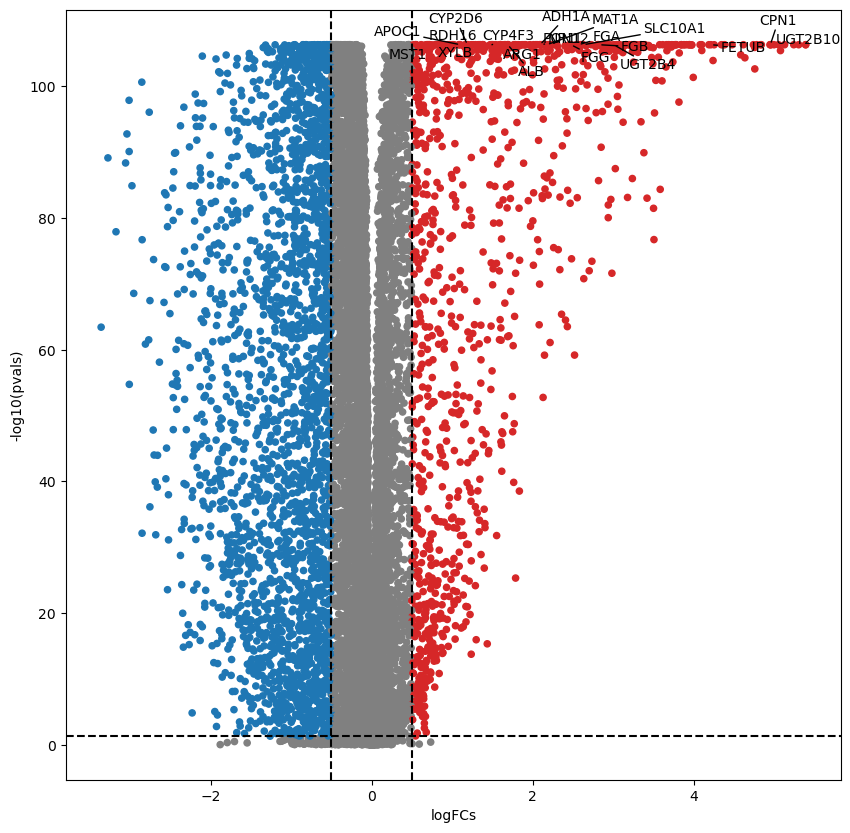

In [6]:
dc.plot_volcano_df(
    results_df,
    x='logfoldchanges',
    y='pvals_adj',
    top=20,
    figsize=(10, 10)
)

## Infer TF activity 

In [7]:
collectri = dc.get_collectri(organism='human', split_complexes=False)
# Infer TF activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)
tf_acts

Running ulm on mat with 1 samples and 17220 targets for 756 sources.


,ABL1,AEBP1,AHR,AHRR,AIP,AIRE,AP1,APEX1,AR,ARID1A,...,ZNF384,ZNF395,ZNF410,ZNF423,ZNF436,ZNF699,ZNF76,ZNF804A,ZNF91,ZXDC
liver.vs.rest,0.195681,0.89201,4.687143,0.932456,0.035484,1.287579,2.484886,2.072095,1.54346,1.514734,...,1.314515,0.835346,-0.055707,-0.336714,-1.978913,0.411325,-0.37966,0.878366,-0.205775,-0.803428


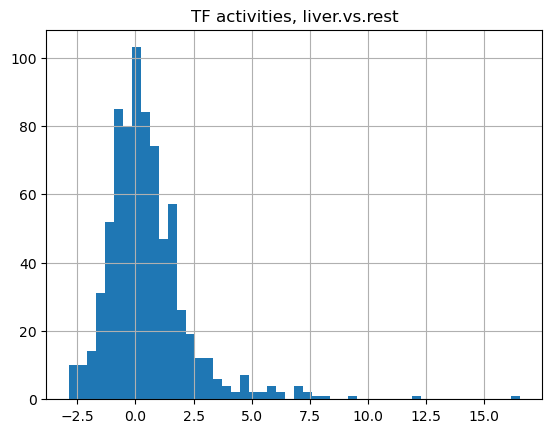

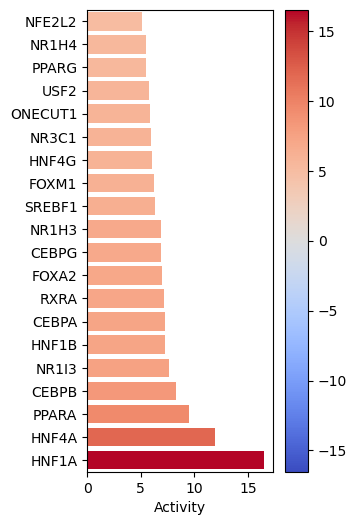

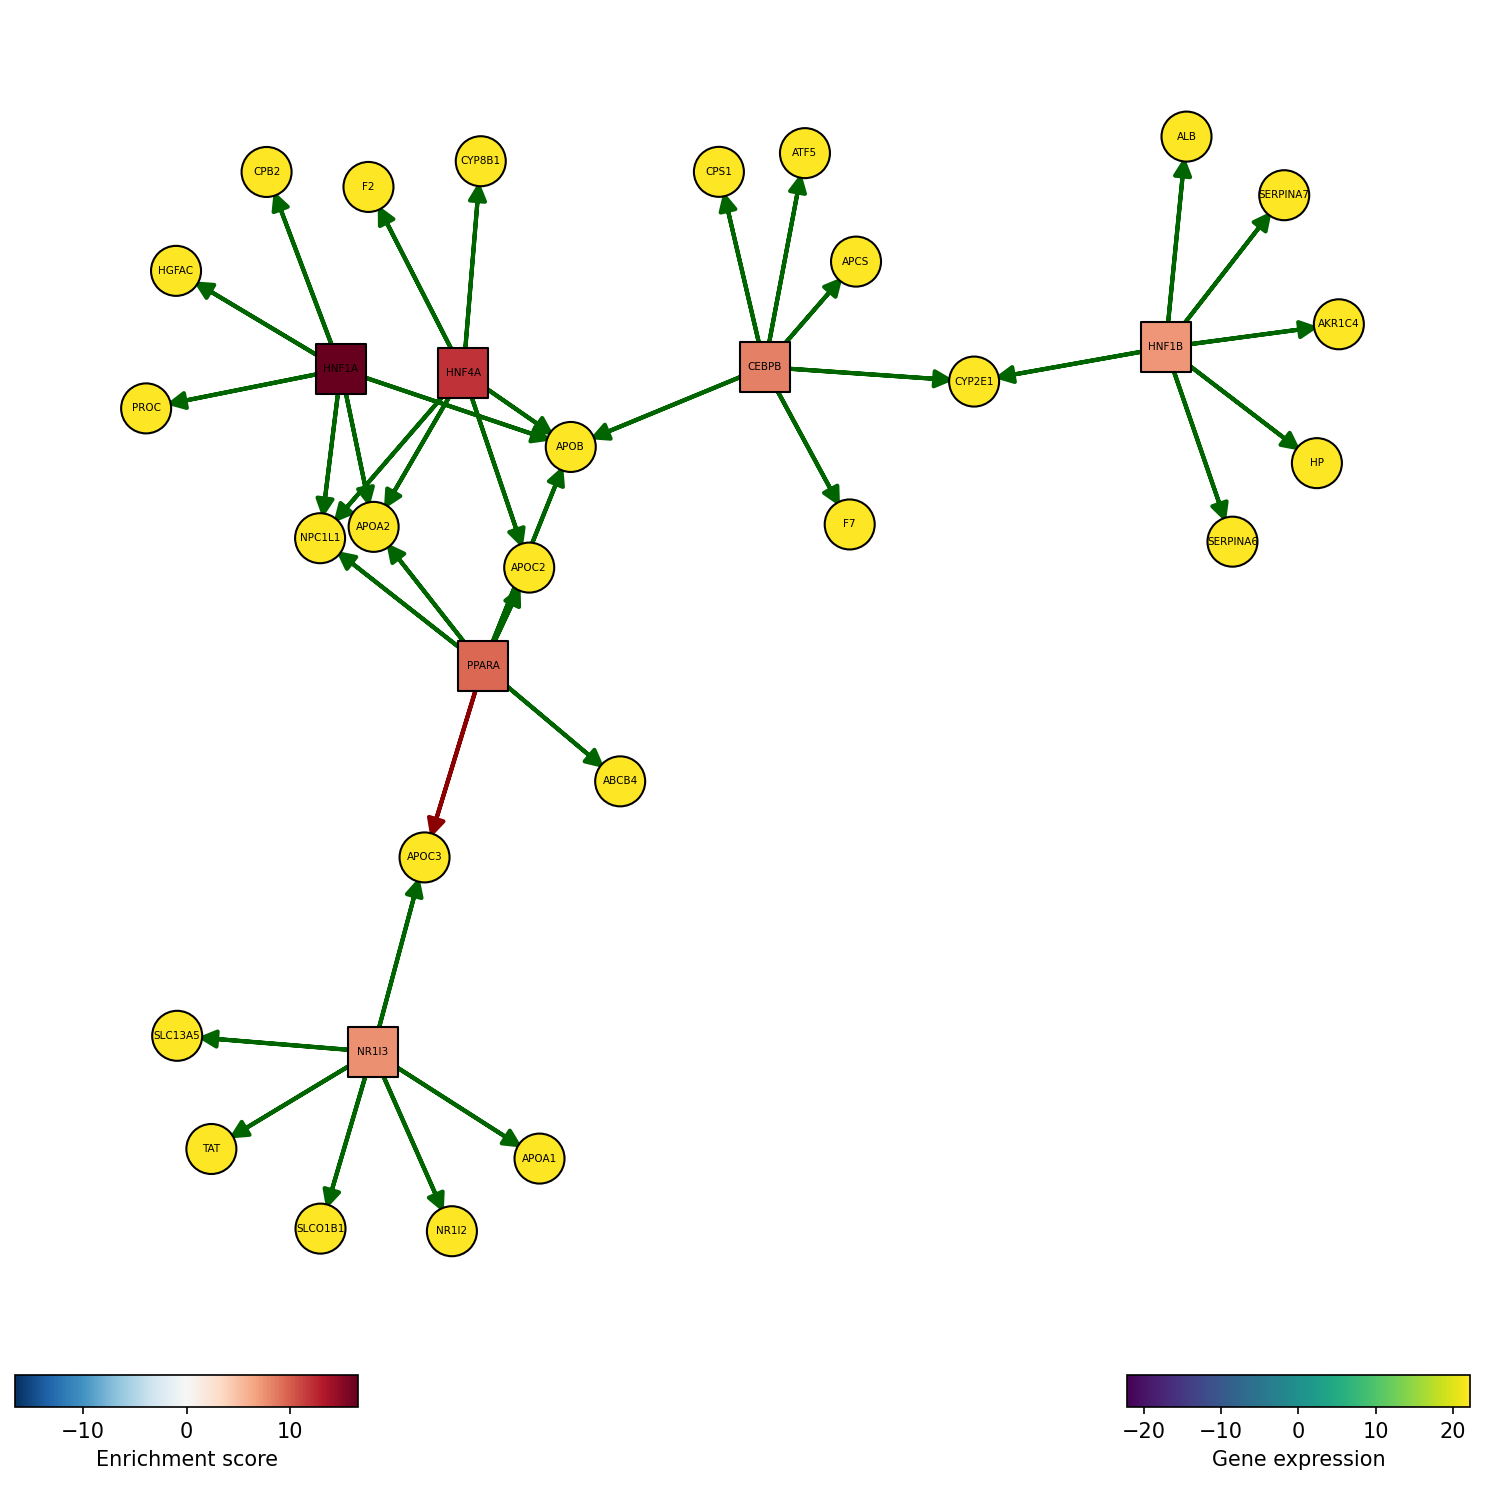

In [10]:
tf_acts.T.hist(bins=50)
plt.title('TF activities, liver.vs.rest')
plt.savefig('../figures/1_TF_activites_hist.png',dpi=100,bbox_inches='tight')
plt.show()

dc.plot_barplot(
    acts=tf_acts,
    contrast='liver.vs.rest',
    top=20,
    vertical=True,
    figsize=(3, 6),
    save='../figures/1_TF_activities_top20_bar.png'
)
dc.plot_network(
    net=collectri,
    obs=mat,
    act=tf_acts,
    n_sources=6,
    n_targets=6,
    node_size=50,
    figsize=(10, 10),
    c_pos_w='darkgreen',
    c_neg_w='darkred',
    vcenter=True,
    save='../figures/1_TF_activities_network.png'

)

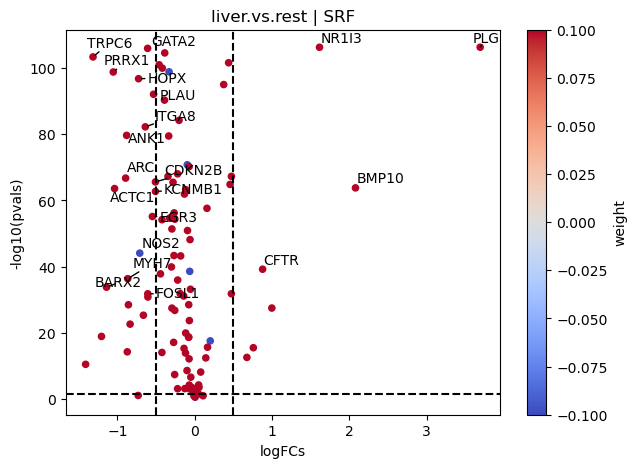

In [11]:
# Extract logFCs and pvals
logFCs = results_df[['logfoldchanges']].T.rename(index={'logfoldchanges': 'liver.vs.rest'})
pvals = results_df[['pvals_adj']].T.rename(index={'pvals_adj': 'liver.vs.rest'})

# Plot
dc.plot_volcano(
    logFCs,
    pvals,
    'liver.vs.rest',
    name='SRF',
    net=collectri,
    top=20,
    sign_thr=0.05,
    lFCs_thr=0.5,
    save='../figures/1_TF_activities_volcano.png'
)

Running mlm on mat with 1 samples and 17220 targets for 14 sources.


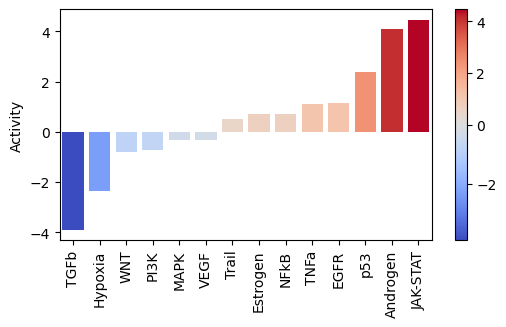

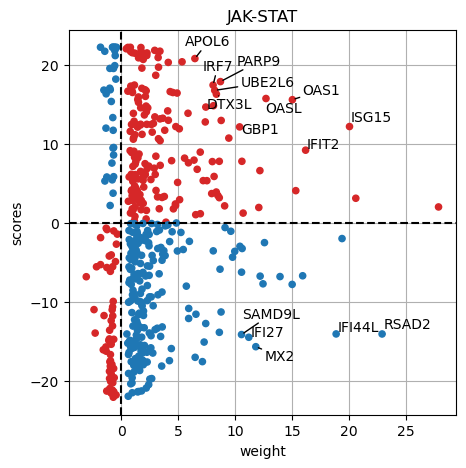

In [166]:
# Retrieve PROGENy model weights
progeny = dc.get_progeny(top=500)
# Infer pathway activities with mlm
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny, verbose=True)
dc.plot_barplot(
    pathway_acts,
    'liver.vs.rest',
    top=25,
    vertical=False,
    figsize=(6, 3)
)
dc.plot_targets(results_df.loc[[c for c in mat.columns if c!='LYNX1']], stat='scores', source_name='JAK-STAT', net=progeny, top=15)

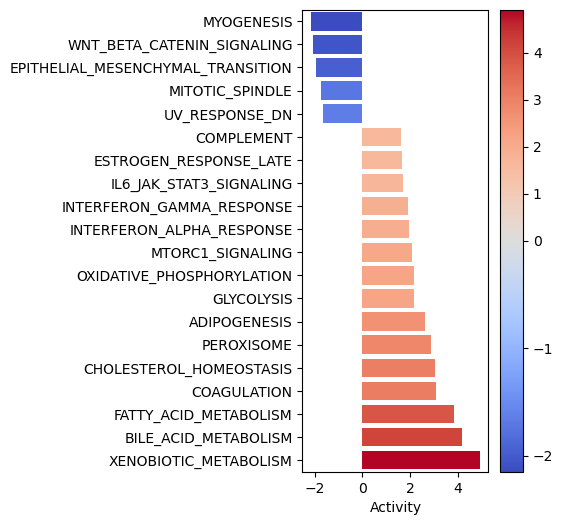

In [75]:
msigdb = dc.get_resource('MSigDB')
msigdb_collection = msigdb[msigdb['collection']=='hallmark']
msigdb_collection = msigdb_collection[~msigdb_collection.duplicated(['geneset', 'genesymbol'])]

# Run gsea
enr_table = dc.get_gsea_df(
    df=results_df,
    stat='scores',
    net=msigdb_collection,
    source='geneset',
    target='genesymbol'
)

enr_nes = enr_table.sort_values('NES',ascending=True).set_index('Term')[['NES']].T
enr_nes.columns = [c.split('HALLMARK_')[1] for c in enr_nes.columns]
dc.plot_barplot(
    enr_nes,
    'NES',
    top=20,
    vertical=True,
    figsize=(3, 6),
    save='../figures/1_msigdb_HALLMARK_top20.png'
)

## Link pathways to TFs 

## PCA on genes

In [ ]:
adata_genes = adata.T.copy()
sc.pp.pca(adata_genes)
sc.pl.pca(adata_genes,ncols=2,annotate_var_explained=True)#,save='qsmooth_PCA_genes.png')